In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import keras_tuner as kt

In [2]:
data=pd.read_csv('Merged_Data.csv',parse_dates=['Tarih'], index_col='Tarih',sep=',',decimal='.',date_format='%Y-%m-%d')
data=data.copy().drop(columns=["Hacim","Fark%","GDP"],axis=1)
#data.dropna(inplace=True)
data.tail(10)


,AdjClose,Açılış,Yüksek,Düşük,M1,Inflation,InterestRate,USD_TRY,BIST100
Tarih,,,,,,,,,
2024-01-03,230.10,235.90,236.00,229.7,5.515378e+09,68.50,44.86,29.69,7412.04
2024-01-04,233.30,230.70,234.30,229.7,5.452040e+09,69.80,44.93,29.75,7547.84
2024-01-05,239.20,233.80,239.20,233.2,5.393797e+09,75.45,45.00,29.82,7628.73
2024-01-06,240.33,235.57,240.83,234.7,5.532444e+09,71.60,45.07,29.84,7692.12
2024-01-07,241.47,237.33,242.47,236.2,5.537031e+09,61.78,45.14,29.86,7755.50
2024-01-08,242.60,239.10,244.10,237.7,5.982992e+09,51.97,45.21,29.88,7818.89
2024-01-09,242.90,243.90,250.50,239.4,6.105518e+09,49.38,45.29,29.87,7736.26
2024-01-10,249.90,242.90,252.25,242.2,6.087428e+09,48.58,45.36,29.95,7874.16
2024-01-11,246.70,250.50,251.50,245.0,6.089273e+09,47.09,45.43,29.96,7895.96


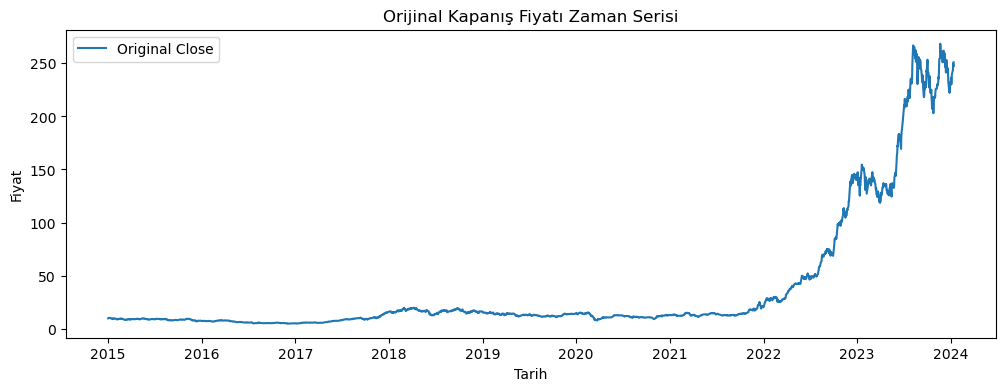

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(data['AdjClose'], label='Original Close')
plt.title("Orijinal Kapanış Fiyatı Zaman Serisi")
plt.xlabel("Tarih")
plt.ylabel("Fiyat")
plt.legend()
plt.show()

C:\Users\onugu\AppData\Local\Temp\ipykernel_15768\19082445.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last6m=data.last('6M')
C:\Users\onugu\AppData\Local\Temp\ipykernel_15768\19082445.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last6m=data.last('6M')


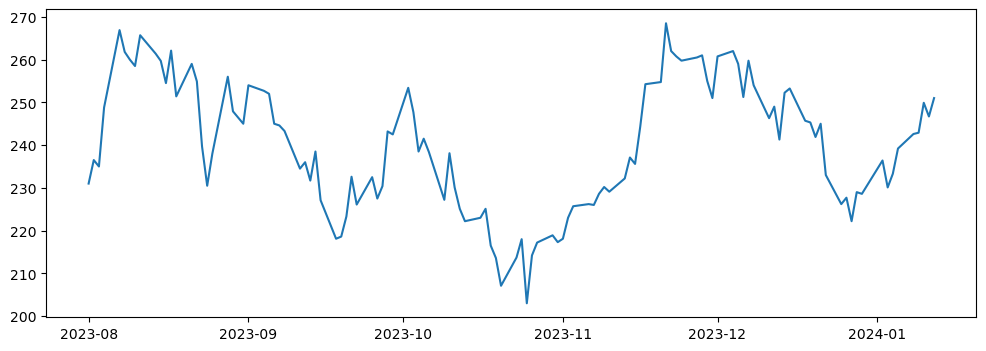

In [4]:
last6m=data.last('6M')
plt.figure(figsize=(12, 4))
plt.plot(last6m['AdjClose'], label='Original Close', )

In [5]:
def adf_test(series, title='ADF Test'):
    print(f"--- {title} ---")
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value:.4f}")
    if result[1] < 0.05:
        print("Seri durağandır.\n")
    else:
        print("Seri durağan değil, dönüşüm uygulanacak.\n")
    return result

# Orijinal seride ADF testi


In [6]:
adf_result = adf_test(data['AdjClose'], title='Orijinal Close Serisi')

--- Orijinal Close Serisi ---
ADF Statistic: 2.1634
p-value: 0.9989
Critical Value (1%): -3.4324
Critical Value (5%): -2.8624
Critical Value (10%): -2.5672
Seri durağan değil, dönüşüm uygulanacak.



In [7]:
data['LogAdjClose'] = np.log(data['AdjClose'])


In [8]:
adf_result = adf_test(data['LogAdjClose'], title='Logaritmik Close Serisi')

--- Logaritmik Close Serisi ---
ADF Statistic: 1.6936
p-value: 0.9981
Critical Value (1%): -3.4323
Critical Value (5%): -2.8624
Critical Value (10%): -2.5672
Seri durağan değil, dönüşüm uygulanacak.



In [9]:
data['DiffLogAdjClose'] = data['LogAdjClose'].diff()
data.dropna(inplace=True)
data.head()

,AdjClose,Açılış,Yüksek,Düşük,M1,Inflation,InterestRate,USD_TRY,BIST100,LogAdjClose,DiffLogAdjClose
Tarih,,,,,,,,,,,
2015-01-03,9.88,9.66,9.93,9.64,261935572.0,7.61,10.90,2.34,857.94,2.290513,0.016327
2015-01-04,10.04,9.71,10.06,9.70,273990507.0,7.91,10.89,2.33,861.28,2.306577,0.016065
2015-01-05,10.20,9.77,10.20,9.75,280246416.0,8.09,10.89,2.33,864.63,2.322388,0.015811
2015-01-06,10.20,10.30,10.45,10.05,285907662.0,7.20,10.89,2.32,869.10,2.322388,0.000000
2015-01-07,10.05,10.25,10.35,9.95,294157799.0,6.81,10.89,2.32,867.77,2.307573,-0.014815


In [10]:
adf_result = adf_test(data['DiffLogAdjClose'], title='Fark Serisi')

--- Fark Serisi ---
ADF Statistic: -17.2891
p-value: 0.0000
Critical Value (1%): -3.4323
Critical Value (5%): -2.8624
Critical Value (10%): -2.5672
Seri durağandır.



In [11]:
feature_cols = ['AdjClose', 'Açılış', 'Yüksek', 'Düşük', 'M1', 'Inflation', 'InterestRate', 'USD_TRY', 'BIST100']
target_col = 'DiffLogAdjClose'

X_all = data[feature_cols].values
y_all = data[[target_col]].values


In [12]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X_all)
y_scaled = y_scaler.fit_transform(y_all)


In [22]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window_size = 4
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)


In [23]:
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [24]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


c:\Users\onugu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1220 - val_loss: 0.0368
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0265
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0108
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0098
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0092
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0155
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0141
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0199
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0160
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - val_loss: 0.0252
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0215
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0257


In [16]:
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_inv = y_scaler.inverse_transform(y_test)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


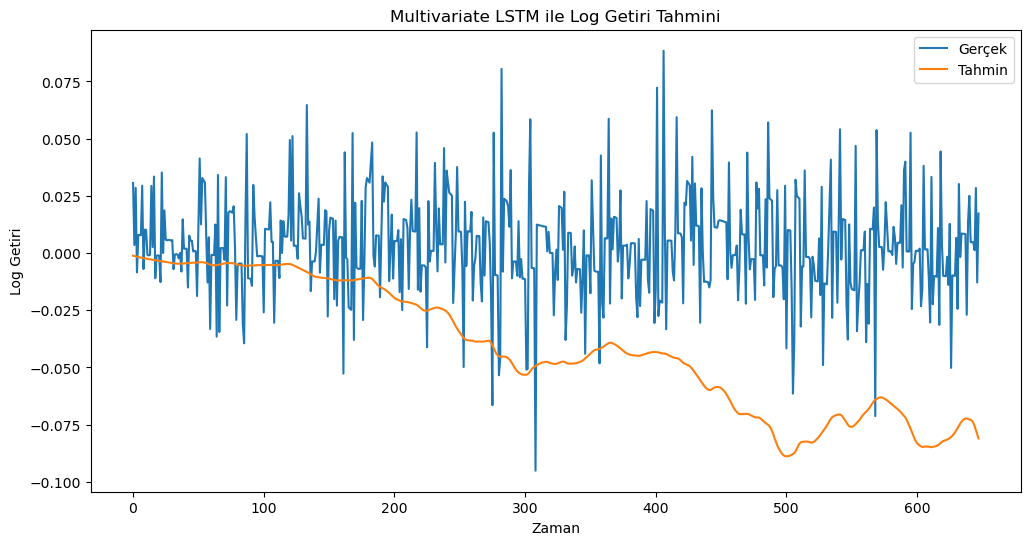

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Gerçek')
plt.plot(y_pred, label='Tahmin')
plt.title('Multivariate LSTM ile Log Getiri Tahmini')
plt.xlabel('Zaman')
plt.ylabel('Log Getiri')
plt.legend()
plt.show()


In [26]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
print("Test RMSE:", rmse)


Test RMSE: 0.05549218126559334


In [27]:
# 1. Tahmin edilen log getiriler
predicted_returns = y_pred.flatten()

# 2. Tahminlerin başladığı yerdeki gerçek log fiyatı
# Bu kısım kritik! Doğrudan 'LogAdjClose' içinden alıyoruz
log_price_start = data['LogAdjClose'].iloc[-len(predicted_returns)]

# 3. Zincirleme log fiyatları oluştur
log_prices = [log_price_start]
for r in predicted_returns:
    log_prices.append(log_prices[-1] + r)

# İlk eleman başlangıç olduğu için çıkar
log_prices = log_prices[1:]

# 4. Log fiyatları → Gerçek fiyatlara çevir
predicted_prices = np.exp(log_prices)

# 5. Gerçek fiyatları karşılaştıralım
true_prices = data['AdjClose'].iloc[-len(predicted_prices):].values

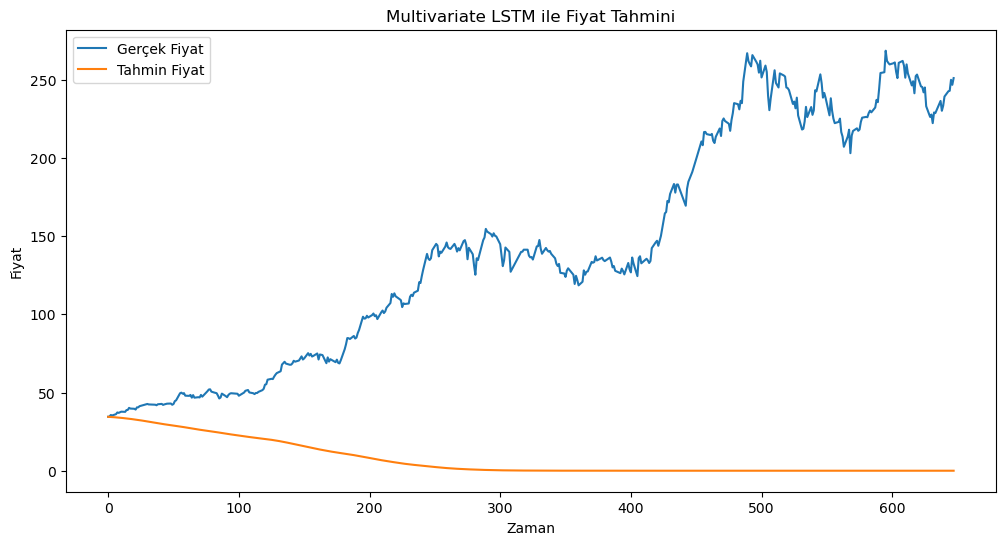

In [28]:
# Gerçek test dönemi fiyatlarını da karşılaştıralım
true_prices = data['AdjClose'].iloc[-len(predicted_prices):].values

plt.figure(figsize=(12, 6))
plt.plot(true_prices, label='Gerçek Fiyat')
plt.plot(predicted_prices, label='Tahmin Fiyat')
plt.title('Multivariate LSTM ile Fiyat Tahmini')
plt.xlabel('Zaman')
plt.ylabel('Fiyat')
plt.legend()
plt.show()


In [21]:
rmse = np.sqrt(mean_squared_error(true_prices, predicted_prices))
print("Test RMSE:", rmse)

Test RMSE: 157.73089546206478
